In [49]:
import utils
import matplotlib.pyplot as plt
from matplotlib import patches
from os import walk, path
import json
import numpy as np
from medpy.io import save, load

plt.rcParams['figure.figsize'] = [10, 10]


In [50]:
config = json.load(open('config.json'))
data_folder_path = config["data_folder_path"]
ct_folder = f'{data_folder_path}/luna16_nodules/nodule_patches/'
mask_folder = f'{data_folder_path}/luna16_nodules/segmentation/'
original_xray_folder = f"{data_folder_path}/original/"
xray_folder = f"{data_folder_path}/generation_data/preprocessed_images/"
lung_segment_folder = f"{data_folder_path}/generation_data/lung_segmentations/"
results_folder = f"{data_folder_path}/extended_training_data/"
evaluation_data_folder = f"{data_folder_path}/evaluation_data/"
training_data_folder = f"{data_folder_path}/preprocessed/"
metadata_folder = f"{data_folder_path}/extended_training_data/metadata/"

_, _, xray_names = next(walk(xray_folder))
_, _, ct_names = next(walk(ct_folder))
_, _, mask_names = next(walk(mask_folder))
_, _, lung_segment_names = next(walk(lung_segment_folder))
_, _, training_data_names = next(walk(training_data_folder))

ct_names = np.sort(ct_names)
mask_names = np.sort(mask_names)
xray_names = np.sort(xray_names)
lung_segment_names = np.sort(lung_segment_names)

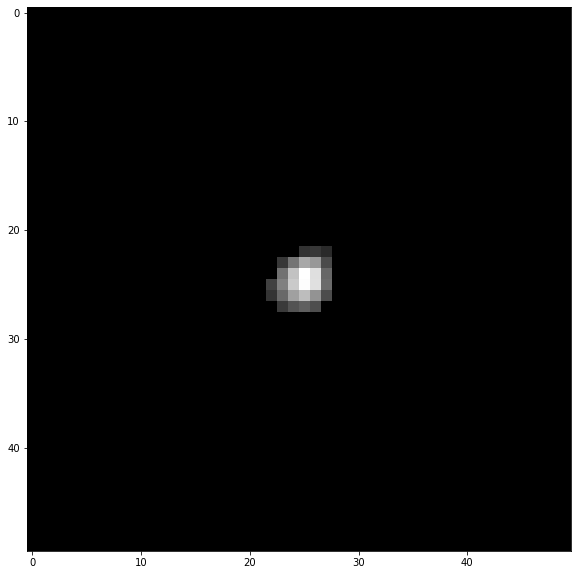

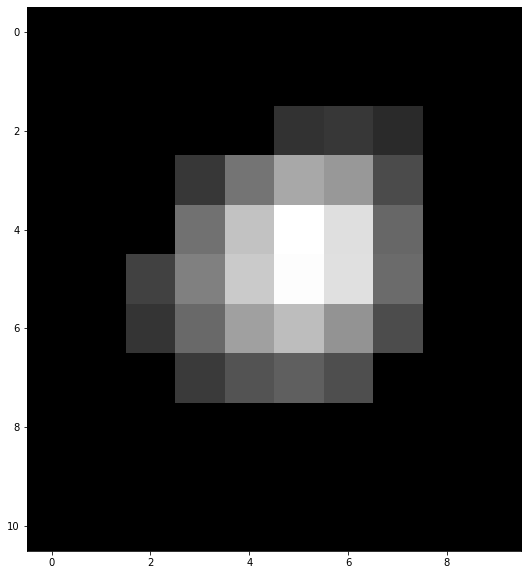

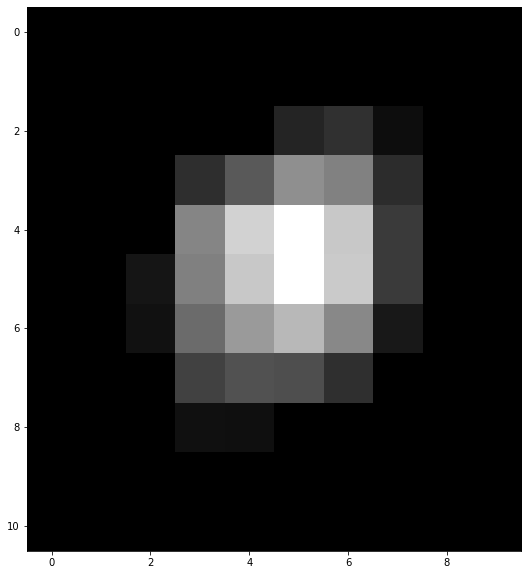

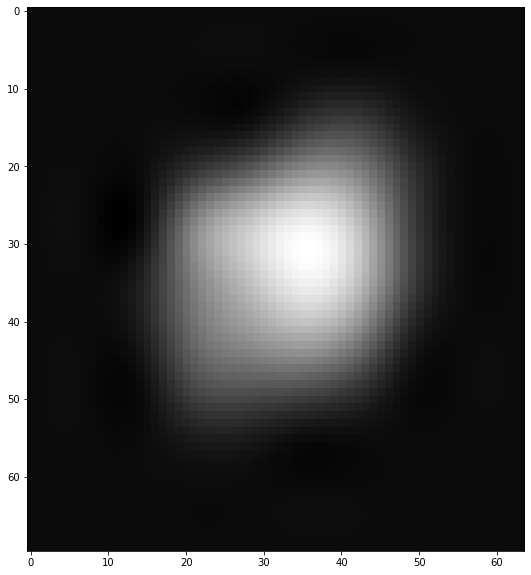

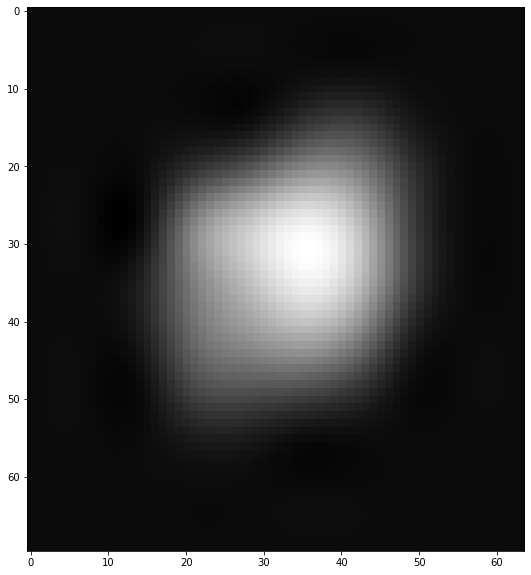

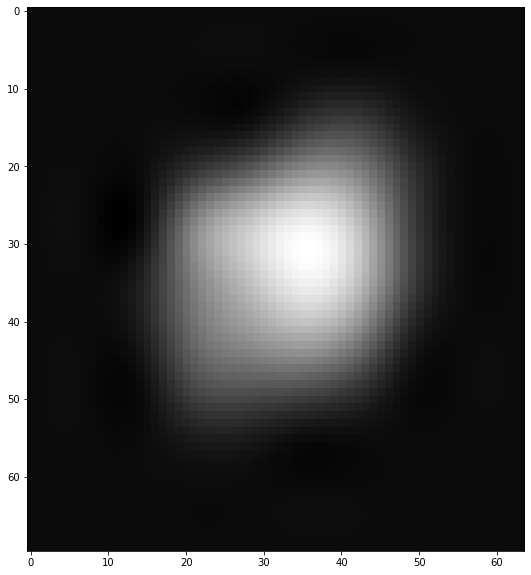

In [51]:
xray_idx = np.random.randint(0,len(xray_names))
xray, xray_header = load(path.join(xray_folder, xray_names[xray_idx]))
xray = xray.astype(float)
spacing = xray_header.get_voxel_spacing()

# pick random nodule and mask
ct_idx = np.random.randint(0, len(ct_names))
ct, ct_header = load(path.join(ct_folder, ct_names[ct_idx]))
ct_mask, ct_mask_header = load(path.join(mask_folder, mask_names[ct_idx]))
imgs = utils.preprocess_nodule(ct, ct_mask, xray, spacing, True)

for img in imgs:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if len(img.shape) > 2:
        ax.imshow(img[:, img.shape[1]//2, :], cmap='gray')
    else:
        ax.imshow(img, cmap='gray')
        
augmented_ct = utils.augment_nodule(imgs[len(imgs)-1])[0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(augmented_ct, cmap='gray')
    
plt.show()


# Lungmask

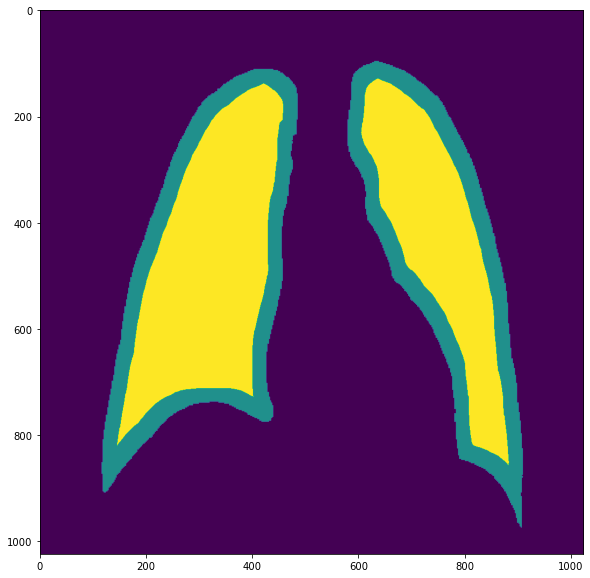

In [52]:
# pick lung mask
lung_mask, _ = load(path.join(lung_segment_folder, lung_segment_names[xray_idx]))
lung_edge_brush_thickness = int(ct.shape[0]/2) if ct.shape[0] > ct.shape[1] else int(ct.shape[1]/2)
lung_mask = utils.preprocess_lung_mask(lung_mask, lung_edge_brush_thickness, 
                                       True)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.imshow(lung_mask.T)


# Superimpose

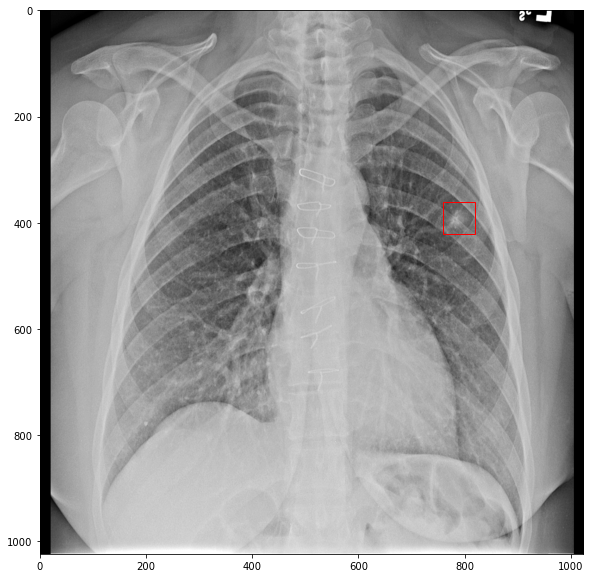

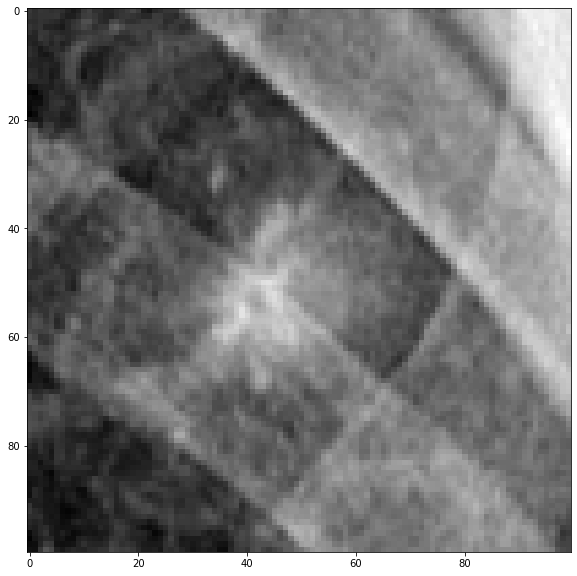

In [53]:

# set spacial parameters based on pre processed lung mask
x, y = utils.get_random_location(lung_mask)
location = (x, y)
width = ct.shape[0] 
height = ct.shape[1]

# normalize nodule to xray range

C = 0.25

result_xray = utils.spherical_superimpose((x,y), augmented_ct, xray, C)


patch_width = 60 if width < 60 else width
patch_height = 60 if height < 60 else height

bb = patches.Rectangle(( int(x-0.5*patch_width), int(y-0.5*patch_height)), 
                        patch_width, patch_height, edgecolor='r',
                        linewidth=1, facecolor='none')

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.imshow(result_xray.T, cmap='gray')
ax1.add_patch(bb)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.imshow(result_xray[x-width:x+width, y-height:y+height].T, cmap = 'gray')

plt.show()